## Pairs Trading with Crypto



In [17]:
import pandas as pd
import ccxt
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

### Setting algorithm parameters

In [18]:
lookback_window = 30 # used for regression
zscore_window = 20 # used for zscore calculation, must be less than lookback_window

upper_threshold = 2
lower_threshold = -2
symbol_one = "XRPUSDT"
symbol_two = "THETAUSDT"

binance = ccxt.binance()

### 1. Data Collection

Grabbing prices. We need to make sure enough datapoints for sufficient backtesting.

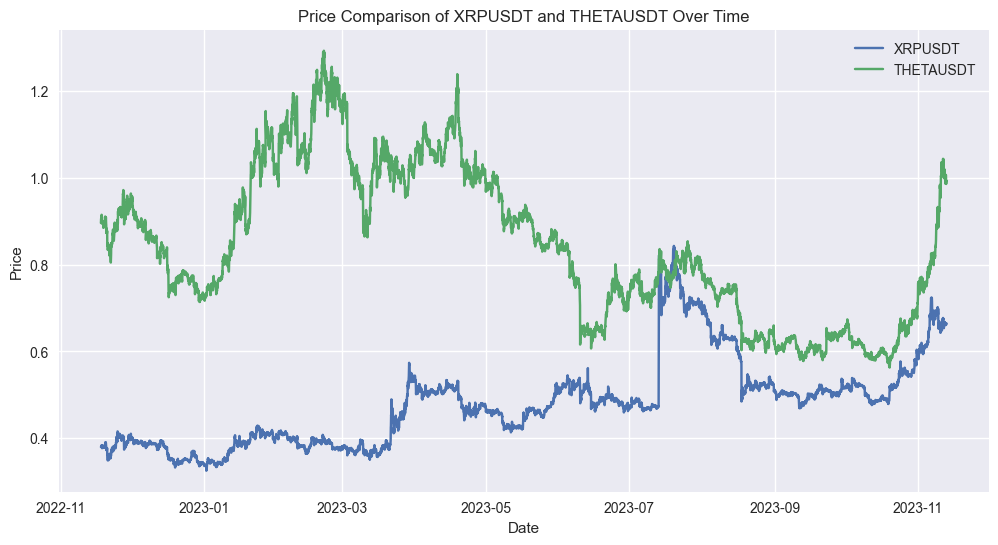

In [22]:
def fetch_prices(binance, symbol_one, symbol_two, look_back_days=30): 
    # Prepare empty dataframe for results
    df_final = pd.DataFrame()
    
    # Calculate the end timestamp for the data fetching
    end_timestamp = binance.milliseconds()
    since_timestamp = end_timestamp - look_back_days * 24 * 60 * 60 * 1000 
    
    while since_timestamp < end_timestamp:
        try:
            # Fetch OHLCV data
            ohlcv_theta = binance.fetch_ohlcv(symbol_two, '1h', since=since_timestamp, limit=1000)
            ohlcv_xrp = binance.fetch_ohlcv(symbol_one, '1h', since=since_timestamp, limit=1000)
            
            # Create temporary dataframes to hold fetched data
            df_theta_temp = pd.DataFrame(ohlcv_theta, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
            df_xrp_temp = pd.DataFrame(ohlcv_xrp, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])

            # Check if both dataframes have the same length
            if len(df_theta_temp) != len(df_xrp_temp):
                print(
                    f"Data length mismatch: {symbol_two} has {len(df_theta_temp)} rows, {symbol_one} has {len(df_xrp_temp)} rows.")
                return None
            
            # Merge dataframes
            df_temp = pd.merge(df_xrp_temp[['timestamp', 'close']], df_theta_temp[['timestamp', 'close']], on='timestamp', how='inner')
            df_temp.columns = ['timestamp', symbol_one, symbol_two]
            
            # Concatenate with the final dataframe
            df_final = pd.concat([df_final, df_temp])
            
            # Update the since_timestamp to the last timestamp fetched
            since_timestamp = df_final['timestamp'].max() + (60 * 60 * 1000)  # Add one hour

        except Exception as e:
            logging.error(f"Error in fetching prices: {e}")
            break
    
    # Remove duplicates and sort the dataframe
    df_final.drop_duplicates(subset='timestamp', keep='first', inplace=True)
    df_final.sort_values(by='timestamp', inplace=True)
    
    return df_final


prices = fetch_prices(binance, symbol_one, symbol_two, 360)

# Convert 'timestamp' to datetime
prices['timestamp'] = pd.to_datetime(prices['timestamp'], unit='ms')

# Set 'timestamp' as the index
prices.set_index('timestamp', inplace=True)

# Ensure there are no duplicates
prices.drop_duplicates(inplace=True)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(prices.index, prices[symbol_one], label=symbol_one)
plt.plot(prices.index, prices[symbol_two], label=symbol_two)

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Price Comparison of {symbol_one} and {symbol_two} Over Time')
plt.legend()

# Display the plot
plt.show()